In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from utils import *
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_regression
from scipy.optimize import curve_fit

DATA_DIR = "../data"

# Load All Dataset

In [2]:
events = ["벤츠 화재", "아이오닉 누수", "아이오닉 iccu", "코나 화재"]
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [3]:
# Read All Posts

total_dfs = []
for event in events:
    per_community_dfs = []
    for community in communities:
        posts_df = pd.read_csv(f'{DATA_DIR}/{event}/{community}_posts.csv') 
        posts_df['from'] = community

        comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
        if community=='clien': #TODO: clien dataset cmt_author, post_id가 바뀌어 있음.
            comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
        comments_df = comments_df.groupby(['post_id'], as_index = False).agg({
            'cmt_author': ['count'],
        })

        comments_df.columns = comments_df.columns.droplevel(0)
        comments_df.columns = ['post_id', 'cmt_count']
        per_community_df = pd.merge(posts_df, comments_df, left_on='id', right_on='post_id', how='left')
        per_community_dfs.append(per_community_df)
    per_event_df = pd.concat(per_community_dfs)
    total_dfs.append(per_event_df)
df = pd.concat(total_dfs)

In [4]:
# Preprocessing
df = df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
df.views = df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
df.likes = df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
df.created_at = df.created_at.apply(parse_dates)
df.cmt_count = df.cmt_count.fillna(0).map(int)

# Split Dataset (Hot Posts / Cold Posts)

In [5]:
top_3_percent_view = get_target_val_by_percent(df, 'views', 0.97)
top_3_percent_number_of_comments = get_target_val_by_percent(df, 'cmt_count', 0.97)
top_3_percent_likes = get_target_val_by_percent(df, 'likes', 0.97)
print(f"top_5_percent_view: {top_3_percent_view} \
    \ntop_5_percent_number_of_comments: {top_3_percent_number_of_comments} \
    \ntop_5_percent_likes: {top_3_percent_likes}"
    )

top_5_percent_view: 10668     
top_5_percent_number_of_comments: 57     
top_5_percent_likes: 19


In [6]:
condition = ((df.views >= top_3_percent_view) \
    | (df.cmt_count>=top_3_percent_number_of_comments) \
    # | (df.likes>=top_3_percent_likes) \
    )
    
df = df.drop(['post_id', 'cmt_count'], axis=1) # Only the information obtained from the posts is kept.

hot_posts_df = df[condition]
cold_posts_df = df[~condition]
assert hot_posts_df.shape[0]+cold_posts_df.shape[0] == df.shape[0]

hot_posts_df.to_csv(f'{DATA_DIR}/splitted/hot_posts.csv', index=False)
cold_posts_df.to_csv(f'{DATA_DIR}/splitted/cold_posts.csv', index=False)

# Modeling (Hot Posts)

In [7]:
events = ["벤츠 화재", "아이오닉 누수", "아이오닉 iccu", "코나 화재"]
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [8]:
# load dataset with full comments info
per_event_comment_dfs = []
for event in events:
    per_community_dfs = []
    for community in communities:
        comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
        comments_df.cmt_created_at = comments_df.cmt_created_at.apply(parse_dates)
        if community=='clien':
            comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
        per_community_dfs.append(comments_df)
    per_event_comment_df = pd.concat(per_community_dfs)
    per_event_comment_dfs.append(per_event_comment_df)
all_comments_df = pd.concat(per_event_comment_dfs)

In [9]:
# Load Dataset
hot_posts_df = pd.read_csv(f'{DATA_DIR}/splitted/hot_posts.csv')
hot_df = pd.merge(hot_posts_df, all_comments_df, left_on='id', right_on='post_id', how='left')

In [10]:
# preprocessing
hot_df = hot_df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
hot_df.views = hot_df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
hot_df.likes = hot_df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
hot_df.created_at = hot_df.created_at.apply(parse_dates)

In [11]:
# Make Relative Time Column (rel_time)

size_of_bin = 30*60 # 30 minutes
time_range = 24 # considering 24 * size_of_bin => currently, 12 hours

hot_df['rel_time'] = hot_df['cmt_created_at'] - hot_df['created_at'] # time delta
hot_df['rel_time'] = hot_df['rel_time'].apply(timedelta_to_seconds) // size_of_bin # applying binnig (30 minutes)
hot_df = hot_df[hot_df.rel_time <= time_range]

In [12]:
number_of_hot_posts = len(hot_df.id.unique())
print(f"number_of_posts: {number_of_hot_posts}")

number_of_posts: 287


Text(0.5, 1.0, 'Distribution of Number of Comments over the Time (Hot Posts)')

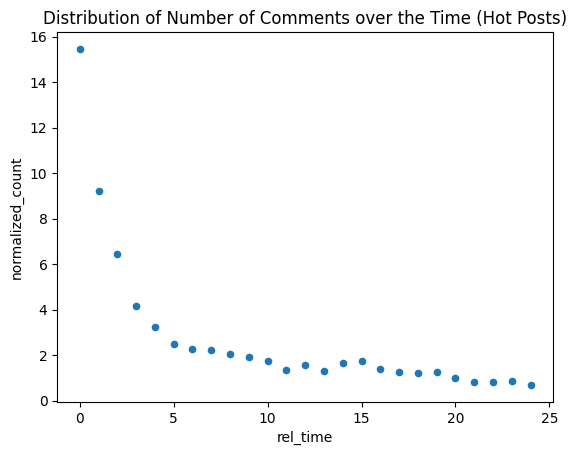

In [13]:
hot_df_gb_rel_time = hot_df.groupby(['rel_time'], as_index=False).agg({
        'cmt_created_at': ['count'],
    })    
hot_df_gb_rel_time.columns = hot_df_gb_rel_time.columns.droplevel(0)
hot_df_gb_rel_time.columns = ['rel_time', 'count']
hot_df_gb_rel_time['normalized_count'] = hot_df_gb_rel_time['count'] / number_of_hot_posts
hot_df_gb_rel_time.plot(x='rel_time', y='normalized_count', kind='scatter')
plt.title("Distribution of Number of Comments over the Time (Hot Posts)")

In [14]:
def hot_func(x, a, b, c, d):
    return a * np.exp(-b * (x - c)) + d

In [15]:
x = hot_df_gb_rel_time['rel_time'].values
y = hot_df_gb_rel_time['normalized_count'].values

popt, pcov = curve_fit(hot_func, x, y)
y_pred_hot = hot_func(x, *popt)
print(popt) # optimized parameter

[6.27625459 0.50448257 1.57487496 1.31901009]


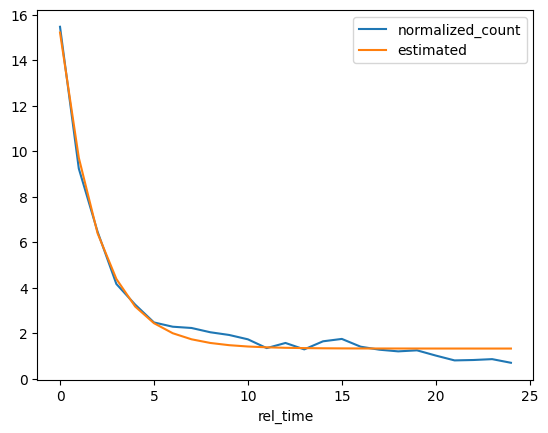

In [16]:
hot_df_gb_rel_time.plot(x='rel_time', y='normalized_count')
plt.plot(x, y_pred_hot, label="estimated")
plt.legend()

# Modeling (Cold Posts)

In [17]:
events = ["벤츠 화재", "아이오닉 누수", "아이오닉 iccu", "코나 화재"]
communities = ['clien', 'bobae', 'fmkorea', 'naver_cafe']

In [18]:
# load dataset with full comments info
per_event_comment_dfs = []
for event in events:
    per_community_dfs = []
    for community in communities:
        comments_df = pd.read_csv(f'../data/{event}/{community}_comments.csv') 
        comments_df.cmt_created_at = comments_df.cmt_created_at.apply(parse_dates)
        if community=='clien':
            comments_df.columns = ['cmt_author', 'cmt_count', 'post_id', 'cmt_created_at']
        per_community_dfs.append(comments_df)
    per_event_comment_df = pd.concat(per_community_dfs)
    per_event_comment_dfs.append(per_event_comment_df)
all_comments_df = pd.concat(per_event_comment_dfs)

In [19]:
# Load Dataset
cold_posts_df = pd.read_csv(f'{DATA_DIR}/splitted/cold_posts.csv')
cold_df = pd.merge(cold_posts_df, all_comments_df, left_on='id', right_on='post_id', how='left')

In [20]:
# preprocessing
cold_df = cold_df.dropna(subset=['created_at']) # 생성 시간이 없는 게시물 제거
cold_df.views = cold_df.views.map(str).apply(remove_commna).apply(convert_str_to_int)
cold_df.likes = cold_df.likes.map(str).apply(remove_commna).apply(convert_str_to_float)
cold_df.created_at = cold_df.created_at.apply(parse_dates)

In [21]:
# Make Relative Time Column (rel_time)
size_of_bin = 30*60 # 30 minutes
time_range = 24 # considering 24 * size_of_bin => currently, 12 hours

cold_df['rel_time'] = cold_df['cmt_created_at'] - cold_df['created_at'] # time delta
cold_df['rel_time'] = cold_df['rel_time'].apply(timedelta_to_seconds) // size_of_bin # applying binnig (30 minutes)
cold_df = cold_df[cold_df.rel_time <= time_range]

In [22]:
number_of_cold_posts = len(cold_df.id.unique())
print(f"number_of_posts: {number_of_cold_posts}")

number_of_posts: 5451


Text(0.5, 1.0, 'Distribution of Number of Comments over the Time (Hot Posts)')

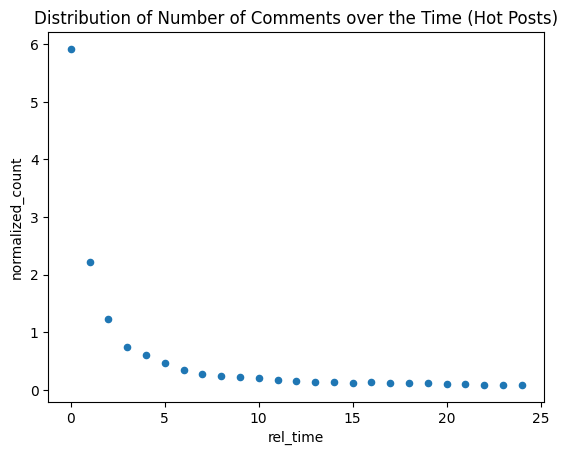

In [23]:
cold_df_gb_rel_time = cold_df.groupby(['rel_time'], as_index=False).agg({
        'cmt_created_at': ['count'],
    })    
cold_df_gb_rel_time.columns = cold_df_gb_rel_time.columns.droplevel(0)
cold_df_gb_rel_time.columns = ['rel_time', 'count']
cold_df_gb_rel_time['normalized_count'] = cold_df_gb_rel_time['count'] / number_of_cold_posts
cold_df_gb_rel_time.plot(x='rel_time', y='normalized_count', kind='scatter')
plt.title("Distribution of Number of Comments over the Time (Hot Posts)")

In [24]:
def cold_func(x, a, b, c, d):
    return a * np.exp(-b * (x - c)) + d

In [25]:
x = cold_df_gb_rel_time['rel_time'].values
y = cold_df_gb_rel_time['normalized_count'].values

popt, pcov = curve_fit(cold_func, x, y)
y_pred_cold = cold_func(x, *popt)
print(popt) # optimized parameter

[0.20836541 0.89354033 3.69482609 0.18250664]


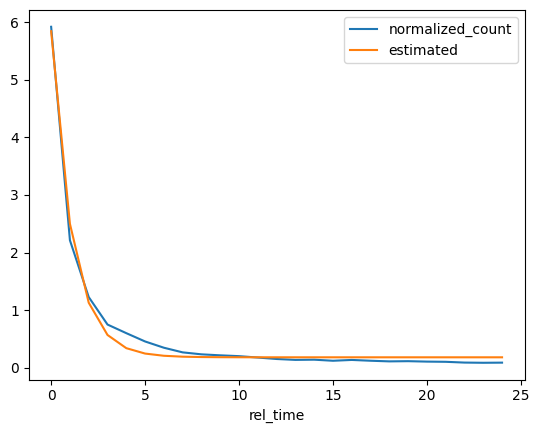

In [26]:
cold_df_gb_rel_time.plot(x='rel_time', y='normalized_count')
plt.plot(x, y_pred_cold, label="estimated")
plt.legend()

# Result

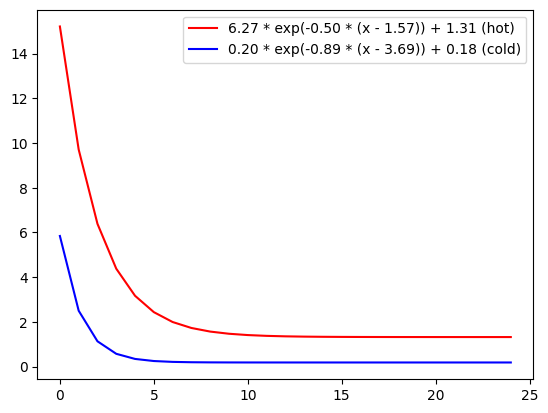

In [28]:
plt.plot(x, y_pred_hot, color='red',label="6.27 * exp(-0.50 * (x - 1.57)) + 1.31 (hot)")
plt.plot(x, y_pred_cold, color='blue', label="0.20 * exp(-0.89 * (x - 3.69)) + 0.18 (cold)")
plt.legend()